# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

1.0510510510510542
217.95897948974488


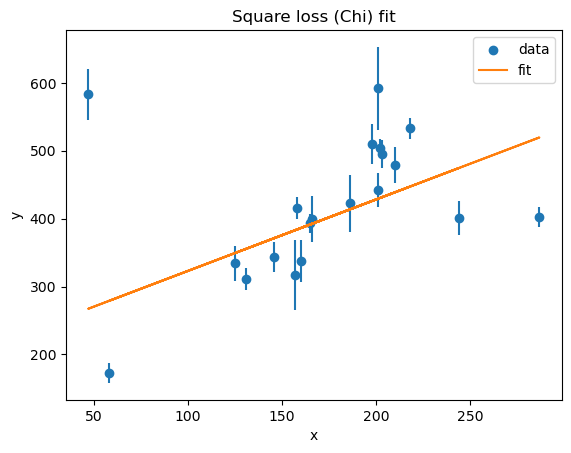

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# function calculates square loss value from fitting parameters a and b
def sq_loss(x_vals, y_vals, dy_vals, a, b):
    y_predict = a*x_vals + b
    loss_val = np.sum(((y_vals-y_predict)/dy_vals)**2)
    #print(loss_val)
    return loss_val

# this just makes plots a bit easier on my laptop - disable as needed
#%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']
plt.scatter(x,y, label = 'data')
plt.errorbar(x, y, dy, ls='none')

a_best = 500
b_best = 500
ln_L_best = -0.5*sq_loss(x, y, dy, a_best, b_best)
#print(ln_L_best)
a_test = np.linspace(-50, 50, 1000)
b_test = np.linspace(-100, 600, 2000)
for i in range(len(a_test)):
    for j in range(len(b_test)):
        ln_L = -0.5*sq_loss(x, y, dy, a_test[i], b_test[j])
        #print(ln_L)
        if ln_L > ln_L_best:
            a_best = a_test[i]
            b_best = b_test[j]
            ln_L_best = ln_L
print(a_best)
print(b_best)
y_fit = a_best*x+b_best
plt.plot(x,y_fit, label = 'fit')
plt.legend()
plt.title('Square loss (Chi) fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

1.4514514514514545
152.12606303151577
2.252252252252255
26.41320660330166


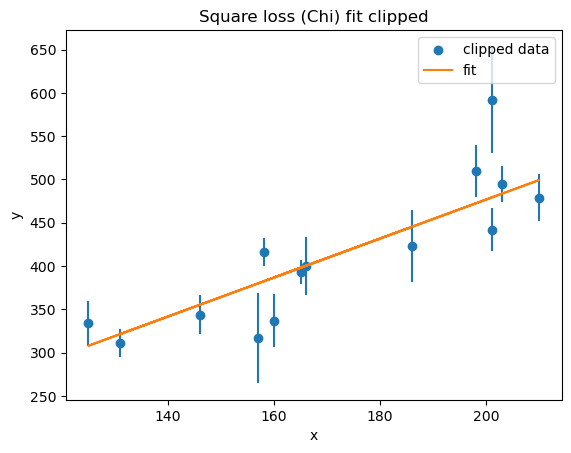

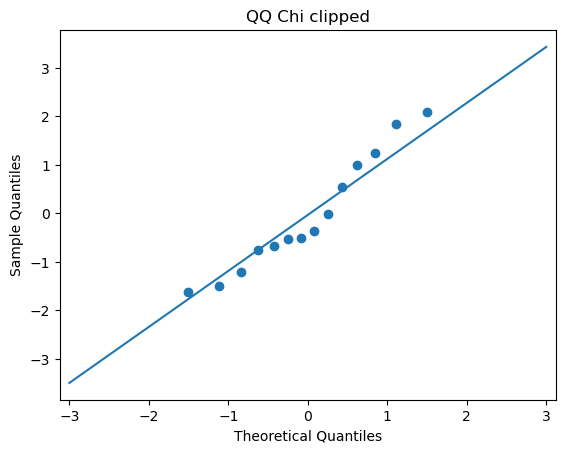

In [7]:
# reject outliers above 4 sigma using sigma clipping
y_clip = np.array(y)
x_clip = np.array(x)
dy_clip = np.array(dy)
y_fit_clip = np.array(y_fit) 

for twittle in range(2):
    rm_list = []

    sigma = abs(y_clip - y_fit_clip)/dy_clip
    for i in range(len(sigma)):
        if sigma[i] > 4:
            rm_list.append(i)
    #print(rm_list)
    sigma = np.delete(sigma, rm_list)
    x_clip = np.delete(x_clip, rm_list)
    y_clip = np.delete(y_clip, rm_list)
    dy_clip = np.delete(dy_clip, rm_list)
    y_fit_clip =np.delete(y_fit_clip, rm_list)
    #print(x)
    #print(x_clip)

    a_best = 500
    b_best = 500
    ln_L_best = -0.5*sq_loss(x_clip, y_clip, dy_clip, a_best, b_best)
    #print(ln_L_best)
    a_test = np.linspace(-50, 50, 1000)
    b_test = np.linspace(-100, 600, 2000)
    for i in range(len(a_test)):
        for j in range(len(b_test)):
            ln_L = -0.5*sq_loss(x_clip, y_clip, dy_clip, a_test[i], b_test[j])
            #print(ln_L)
            if ln_L > ln_L_best:
                a_best = a_test[i]
                b_best = b_test[j]
                ln_L_best = ln_L
    print(a_best)
    print(b_best)
    y_fit_clip = a_best*x_clip+b_best

plt.scatter(x_clip,y_clip, label='clipped data')
plt.errorbar(x_clip, y_clip, dy_clip, ls='none')
plt.plot(x_clip,y_fit_clip, label='fit')
plt.title('Square loss (Chi) fit clipped')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
#sigma = abs(y_clip - y_fit_clip)/dy_clip
#print(sigma)
residuals = y_clip - y_fit_clip
z = (residuals - np.mean(residuals))/dy_clip
sm.qqplot(z)
x_qq = np.linspace(-3, 3, 100)
y_qq = np.mean(z) + np.std(z)*x_qq
plt.plot(x_qq, y_qq)
plt.title('QQ Chi clipped')

plt.show()

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 61
         Function evaluations: 112
1.9647314576407153
70.00569962418069


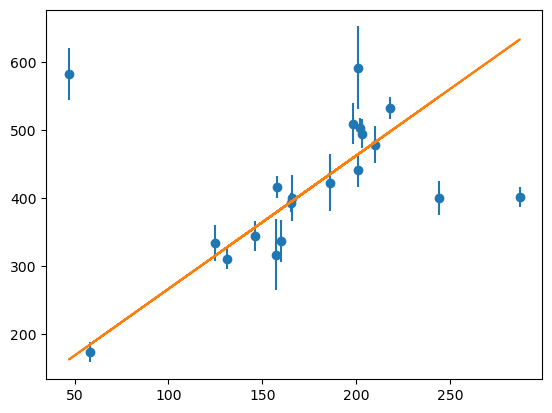

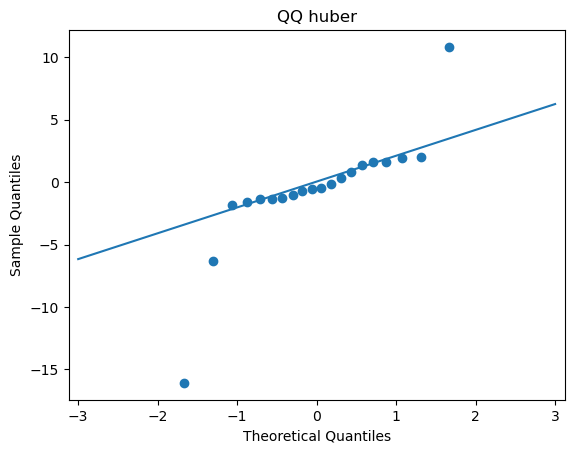

In [8]:
import scipy.stats as st

# Huber loss function to minimize
def H_loss(vars_x0, x_vals, y_vals, dy_vals):
    a = vars_x0[0]
    b = vars_x0[1]
    #del_h = vars_x0[2]
    del_h = 1
    y_predict = a*x_vals + b
    loss_val = 0.0
    for i in range(len(y_vals)):
        arg = abs(y_vals[i]-y_predict[i])/dy_vals[i]
        if arg < del_h:
            loss_val = loss_val + 0.5* ((y_vals[i]-y_predict[i])/dy_vals[i])**2
        else:
            loss_val = loss_val + del_h*((abs(y_vals[i]-y_predict[i])/dy_vals[i]) - 0.5*del_h)
     
    #loss_val = np.sum(((y_vals-y_predict)/dy_vals)**2)
  
    #print(loss_val)
    return loss_val

minimum = scipy.optimize.fmin(H_loss, [2, 26], args = (x, y, dy))
print(minimum[0])
print(minimum[1])
a_bestH = minimum[0]
b_bestH = minimum[1]
plt.scatter(x,y, label='data')
plt.errorbar(x, y, dy, ls='none')
y_fit_H = a_bestH*x+b_bestH
plt.plot(x,y_fit_H, label='Huber fit')
plt.show()
residuals = y - y_fit_H
z = (residuals - np.mean(residuals))/dy
sm.qqplot(z)

q25, q75 = np.percentile(z, 25), np.percentile(z, 75)
iqr = q75-q25
x25, x75 = st.norm.ppf(0.25), st.norm.ppf(0.75)

x_qq = np.linspace(-3, 3, 100)
y_qq = q25 + (iqr/(x75-x25) )* (x_qq - x25)

plt.title('QQ huber')
plt.plot(x_qq, y_qq)
plt.show()



## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

Optimization terminated successfully.
         Current function value: 18.398982
         Iterations: 38
         Function evaluations: 75


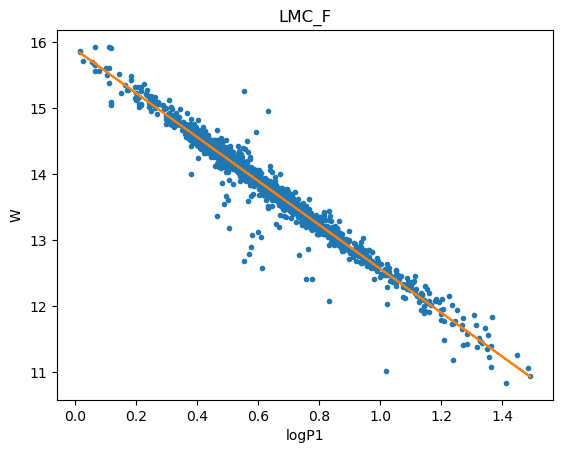

Optimization terminated successfully.
         Current function value: 14.042800
         Iterations: 35
         Function evaluations: 66


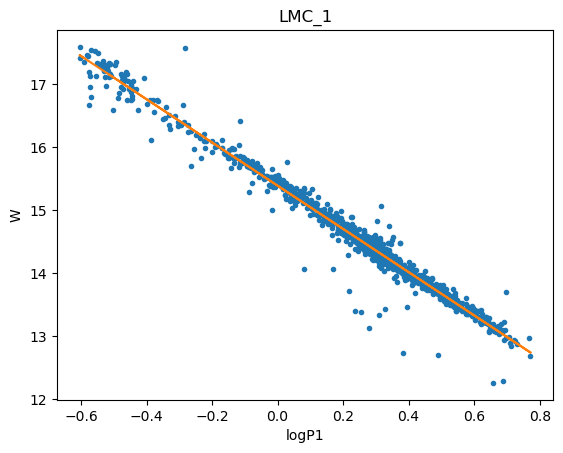

Optimization terminated successfully.
         Current function value: 56.180731
         Iterations: 45
         Function evaluations: 88


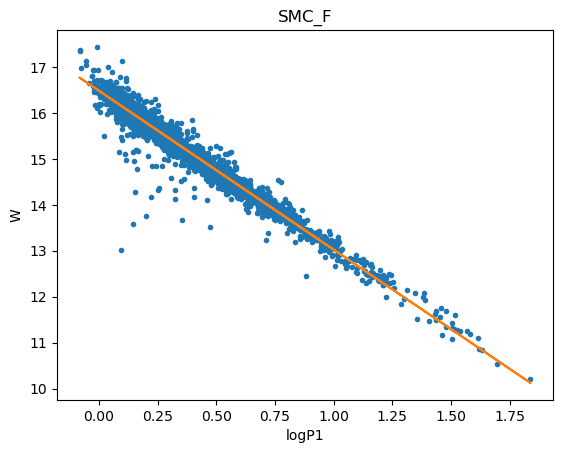

Optimization terminated successfully.
         Current function value: 38.603509
         Iterations: 36
         Function evaluations: 70


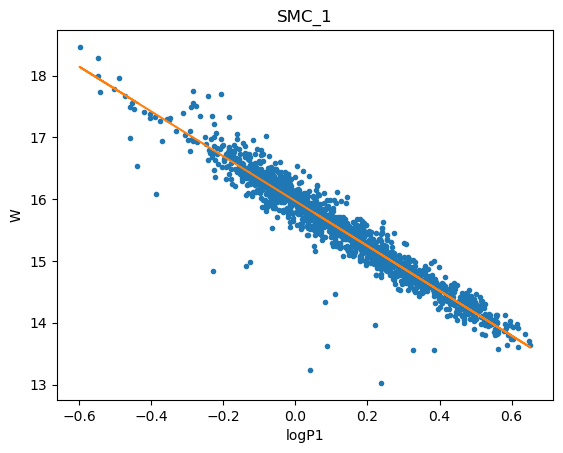

In [9]:
#long period Cepheids brighter than short period Cepheids
import pandas as pd

def H_loss_no_er(vars_x0, x_vals, y_vals):
    a = vars_x0[0]
    b = vars_x0[1]
    #del_h = vars_x0[2]
    del_h = 1
    y_predict = a*x_vals + b
    loss_val = 0.0
    for i in range(len(y_vals)):
        arg = abs(y_vals[i]-y_predict[i])
        if arg < del_h:
            loss_val = loss_val + 0.5* ((y_vals[i]-y_predict[i]))**2
        else:
            loss_val = loss_val + del_h*((abs(y_vals[i]-y_predict[i])) - 0.5*del_h)
     
    #loss_val = np.sum(((y_vals-y_predict)/dy_vals)**2)
  
    #print(loss_val)
    return loss_val

File_1 = pd.read_csv('Cepheids.csv')
#print(File_1)

LMC = File_1[File_1['Cloud'] == 'LMC']
SMC = File_1[File_1['Cloud'] == 'SMC']

LMC_F = LMC[LMC['Mode'] == 'F']
LMC_1 = LMC[LMC['Mode'] == '1']

SMC_F = SMC[SMC['Mode'] == 'F']
SMC_1 = SMC[SMC['Mode'] == '1']

plt.plot(LMC_F['logP1'], LMC_F['W'], '.')
plt.title('LMC_F')
plt.xlabel('logP1')
plt.ylabel('W')

min_LMC_F = scipy.optimize.fmin(H_loss_no_er, [-4, 15.5], args = (np.array(LMC_F['logP1']), np.array(LMC_F['W'])))

a_LMC_F = min_LMC_F[0]
b_LMC_F = min_LMC_F[1]

fit_LMC_F = a_LMC_F*LMC_F['logP1']+b_LMC_F
plt.plot(LMC_F['logP1'],fit_LMC_F)

resid_LMC_F = LMC_F['W'] - fit_LMC_F
plt.show()

plt.plot(LMC_1['logP1'], LMC_1['W'], '.')
plt.title('LMC_1')
plt.xlabel('logP1')
plt.ylabel('W')

min_LMC_1 = scipy.optimize.fmin(H_loss_no_er, [-4, 15.5], args = (np.array(LMC_1['logP1']), np.array(LMC_1['W'])))

a_LMC_1 = min_LMC_1[0]
b_LMC_1 = min_LMC_1[1]

fit_LMC_1 = a_LMC_1*LMC_1['logP1']+b_LMC_1
plt.plot(LMC_1['logP1'],fit_LMC_1)

resid_LMC_1 = LMC_1['W'] - fit_LMC_1

plt.show()

plt.plot(SMC_F['logP1'], SMC_F['W'], '.')
plt.title('SMC_F')
plt.xlabel('logP1')
plt.ylabel('W')

min_SMC_F = scipy.optimize.fmin(H_loss_no_er, [-4, 15.5], args = (np.array(SMC_F['logP1']), np.array(SMC_F['W'])))

a_SMC_F = min_SMC_F[0]
b_SMC_F = min_SMC_F[1]

fit_SMC_F = a_SMC_F*SMC_F['logP1']+b_SMC_F
plt.plot(SMC_F['logP1'],fit_SMC_F)

resid_SMC_F = SMC_F['W'] - fit_SMC_F

plt.show()

plt.plot(SMC_1['logP1'], SMC_1['W'], '.')
plt.title('SMC_1')
plt.xlabel('logP1')
plt.ylabel('W')

min_SMC_1 = scipy.optimize.fmin(H_loss_no_er, [-4, 15.5], args = (np.array(SMC_1['logP1']), np.array(SMC_1['W'])))

a_SMC_1 = min_SMC_1[0]
b_SMC_1 = min_SMC_1[1]

fit_SMC_1 = a_SMC_1*SMC_1['logP1']+b_SMC_1
plt.plot(SMC_1['logP1'],fit_SMC_1)

resid_SMC_1 = SMC_1['W'] - fit_SMC_1

plt.show()



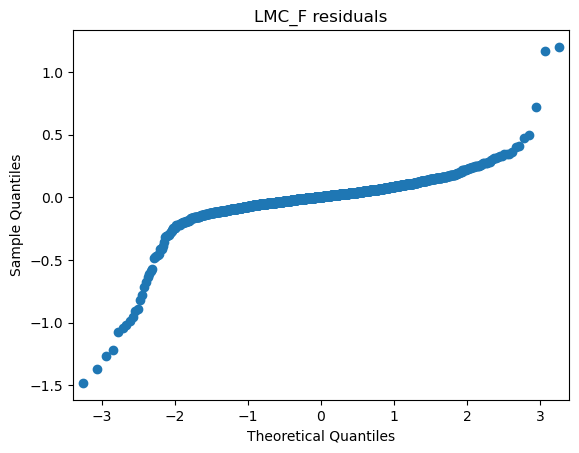

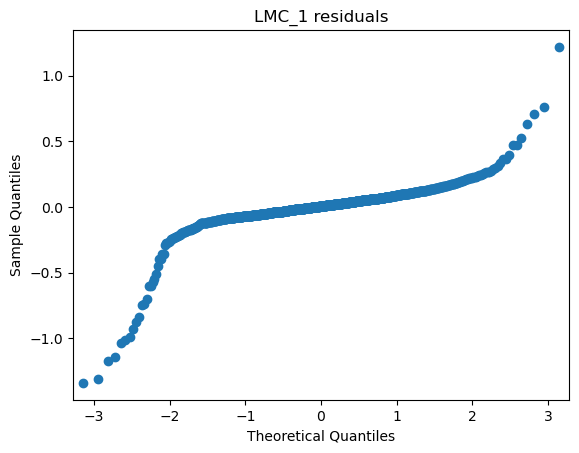

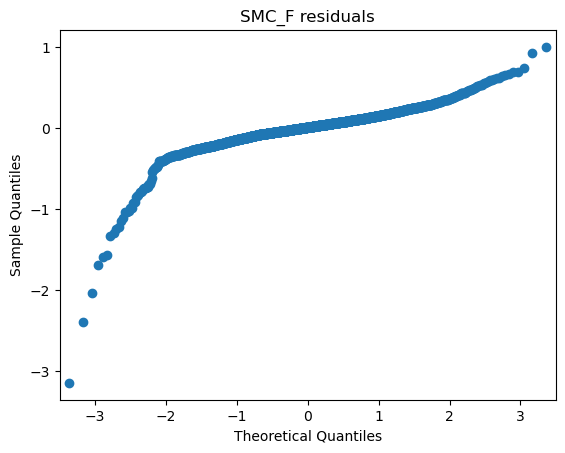

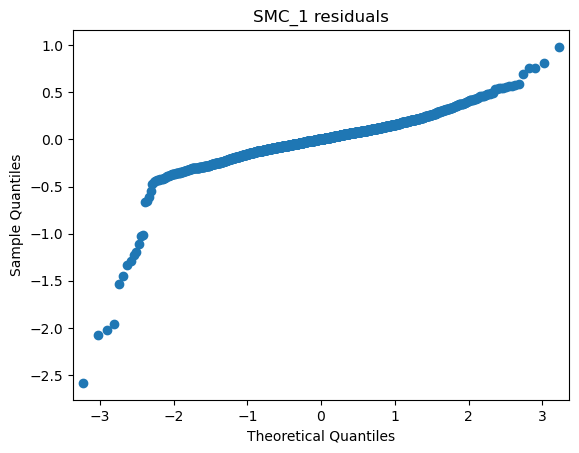

In [18]:
sm.qqplot(resid_LMC_F)
plt.title('LMC_F residuals')
plt.show()

sm.qqplot(resid_LMC_1)
plt.title('LMC_1 residuals')
plt.show()

sm.qqplot(resid_SMC_F)
plt.title('SMC_F residuals')
plt.show()

sm.qqplot(resid_SMC_1)
plt.title('SMC_1 residuals')
plt.show()

These residuals do not look Guassian. Instead they appear closer to a Cauchy distribution. This may be because the relationship between a Cepheids' period and luminosity are very tightly related such that a guassian cannot properly describe the residuals we observe. Data is distributed much closer to the relationship than in a gaussian.

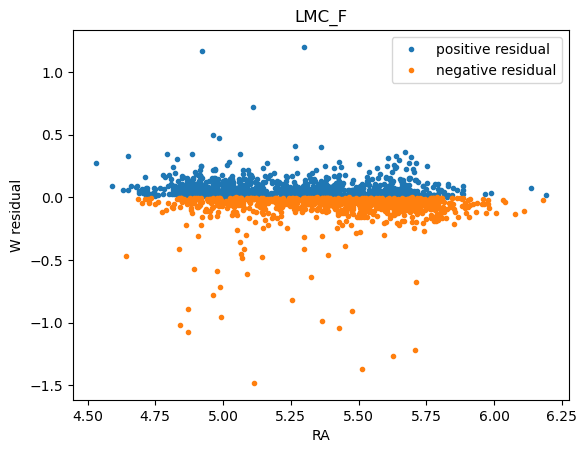

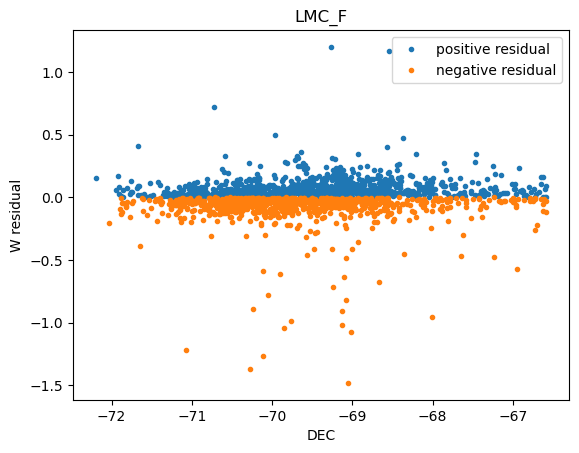

In [27]:
# Residuals vs RA and DEC

#LMC_F.loc[resid_LMC_F > 0, 'RA0']
#resid_LMC_F[resid_LMC_F > 0]

plt.plot(LMC_F.loc[resid_LMC_F > 0, 'RA0'], resid_LMC_F[resid_LMC_F > 0], '.', label='positive residual')
plt.plot(LMC_F.loc[resid_LMC_F < 0, 'RA0'], resid_LMC_F[resid_LMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_F')
plt.xlabel('RA')
plt.ylabel('W residual')
plt.show()

plt.plot(LMC_F.loc[resid_LMC_F > 0, 'Decl0'], resid_LMC_F[resid_LMC_F > 0], '.', label='positive residual')
plt.plot(LMC_F.loc[resid_LMC_F < 0, 'Decl0'], resid_LMC_F[resid_LMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_F')
plt.xlabel('DEC')
plt.ylabel('W residual')
plt.show()

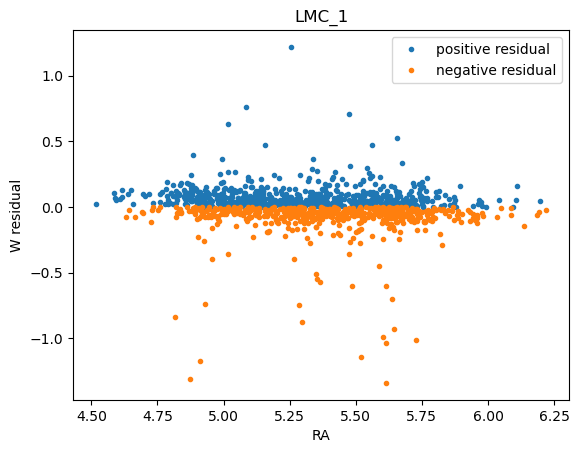

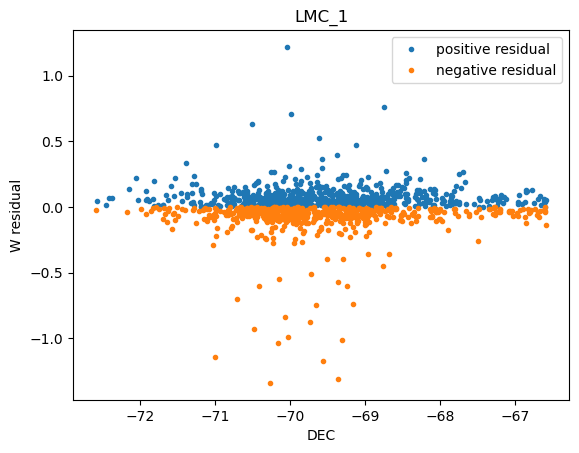

In [29]:
plt.plot(LMC_1.loc[resid_LMC_1 > 0, 'RA0'], resid_LMC_1[resid_LMC_1 > 0], '.', label='positive residual')
plt.plot(LMC_1.loc[resid_LMC_1 < 0, 'RA0'], resid_LMC_1[resid_LMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_1')
plt.xlabel('RA')
plt.ylabel('W residual')
plt.show()

plt.plot(LMC_1.loc[resid_LMC_1 > 0, 'Decl0'], resid_LMC_1[resid_LMC_1 > 0], '.', label='positive residual')
plt.plot(LMC_1.loc[resid_LMC_1 < 0, 'Decl0'], resid_LMC_1[resid_LMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_1')
plt.xlabel('DEC')
plt.ylabel('W residual')
plt.show()

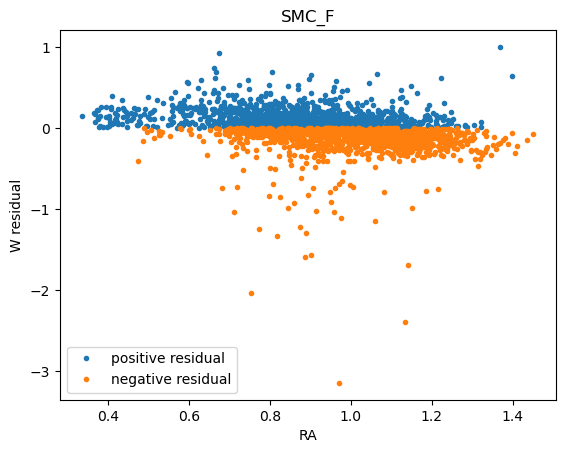

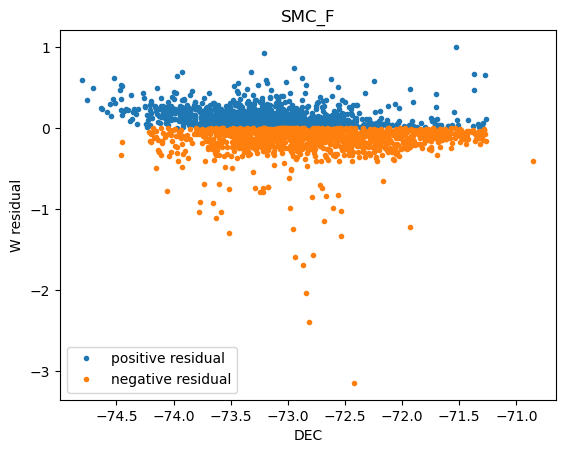

In [30]:
plt.plot(SMC_F.loc[resid_SMC_F > 0, 'RA0'], resid_SMC_F[resid_SMC_F > 0], '.', label='positive residual')
plt.plot(SMC_F.loc[resid_SMC_F < 0, 'RA0'], resid_SMC_F[resid_SMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_F')
plt.xlabel('RA')
plt.ylabel('W residual')
plt.show()

plt.plot(SMC_F.loc[resid_SMC_F > 0, 'Decl0'], resid_SMC_F[resid_SMC_F > 0], '.', label='positive residual')
plt.plot(SMC_F.loc[resid_SMC_F < 0, 'Decl0'], resid_SMC_F[resid_SMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_F')
plt.xlabel('DEC')
plt.ylabel('W residual')
plt.show()

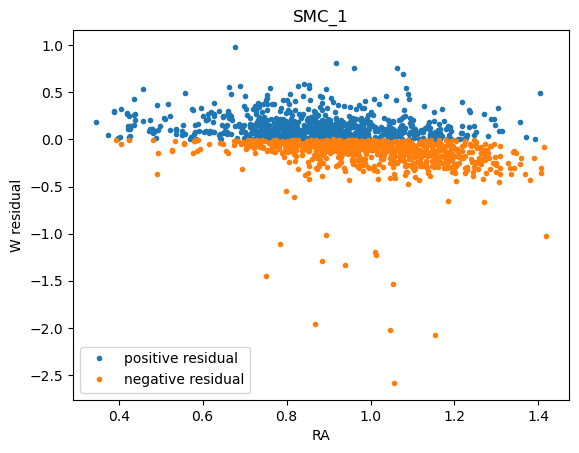

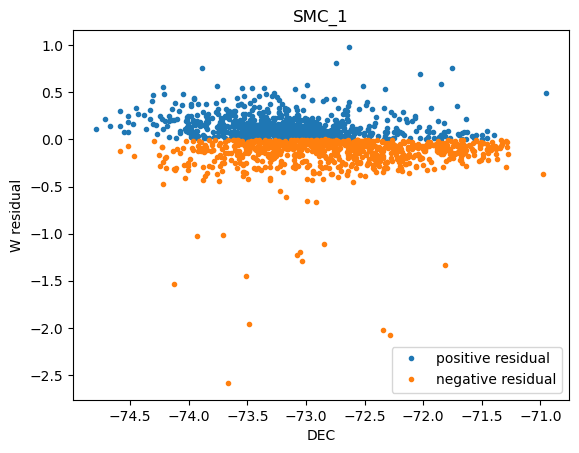

In [31]:
plt.plot(SMC_1.loc[resid_SMC_1 > 0, 'RA0'], resid_SMC_1[resid_SMC_1 > 0], '.', label='positive residual')
plt.plot(SMC_1.loc[resid_SMC_1 < 0, 'RA0'], resid_SMC_1[resid_SMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_1')
plt.xlabel('RA')
plt.ylabel('W residual')
plt.show()

plt.plot(SMC_1.loc[resid_SMC_1 > 0, 'Decl0'], resid_SMC_1[resid_SMC_1 > 0], '.', label='positive residual')
plt.plot(SMC_1.loc[resid_SMC_1 < 0, 'Decl0'], resid_SMC_1[resid_SMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_1')
plt.xlabel('DEC')
plt.ylabel('W residual')
plt.show()

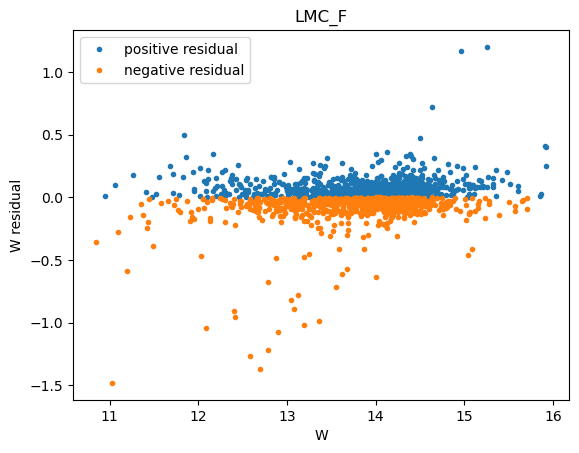

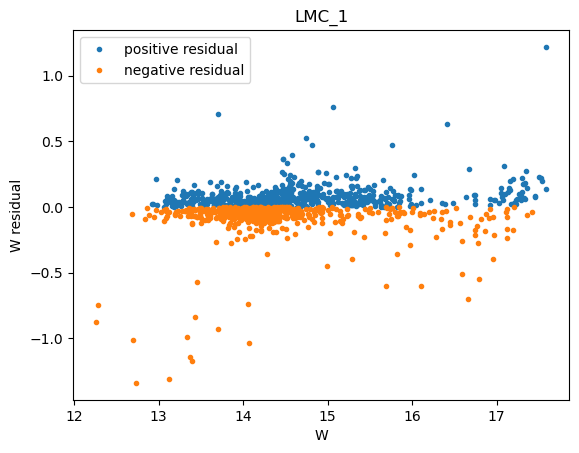

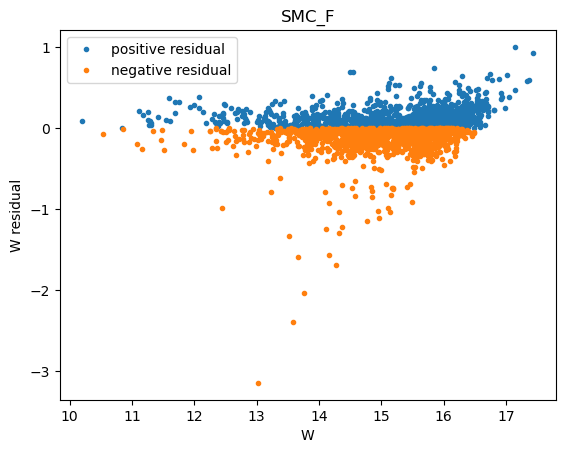

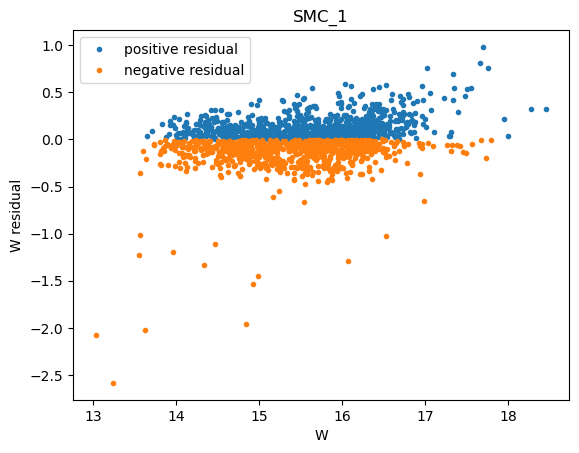

In [33]:
# Residuals VS W

plt.plot(LMC_F.loc[resid_LMC_F > 0, 'W'], resid_LMC_F[resid_LMC_F > 0], '.', label='positive residual')
plt.plot(LMC_F.loc[resid_LMC_F < 0, 'W'], resid_LMC_F[resid_LMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_F')
plt.xlabel('W')
plt.ylabel('W residual')
plt.show()

plt.plot(LMC_1.loc[resid_LMC_1 > 0, 'W'], resid_LMC_1[resid_LMC_1 > 0], '.', label='positive residual')
plt.plot(LMC_1.loc[resid_LMC_1 < 0, 'W'], resid_LMC_1[resid_LMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('LMC_1')
plt.xlabel('W')
plt.ylabel('W residual')
plt.show()

plt.plot(SMC_F.loc[resid_SMC_F > 0, 'W'], resid_SMC_F[resid_SMC_F > 0], '.', label='positive residual')
plt.plot(SMC_F.loc[resid_SMC_F < 0, 'W'], resid_SMC_F[resid_SMC_F < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_F')
plt.xlabel('W')
plt.ylabel('W residual')
plt.show()

plt.plot(SMC_1.loc[resid_SMC_1 > 0, 'W'], resid_SMC_1[resid_SMC_1 > 0], '.', label='positive residual')
plt.plot(SMC_1.loc[resid_SMC_1 < 0, 'W'], resid_SMC_1[resid_SMC_1 < 0], '.', label='negative residual')
plt.legend()
plt.title('SMC_1')
plt.xlabel('W')
plt.ylabel('W residual')
plt.show()

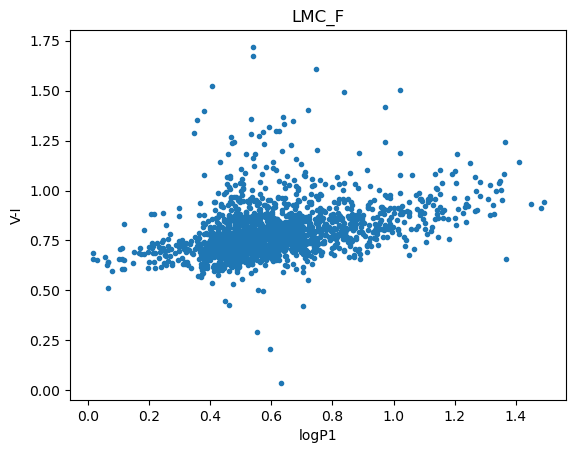

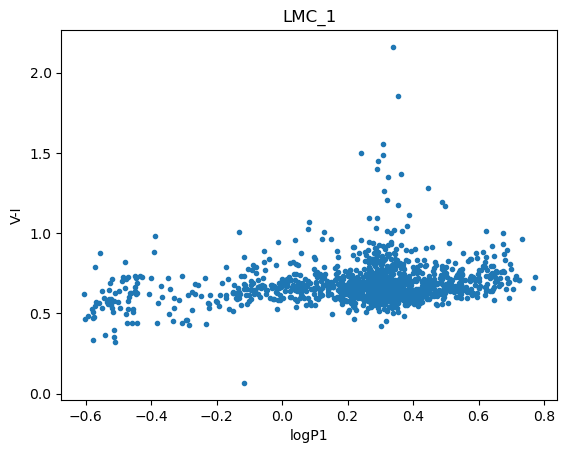

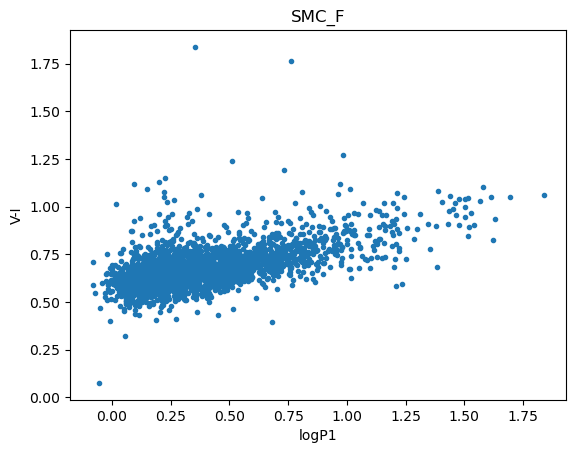

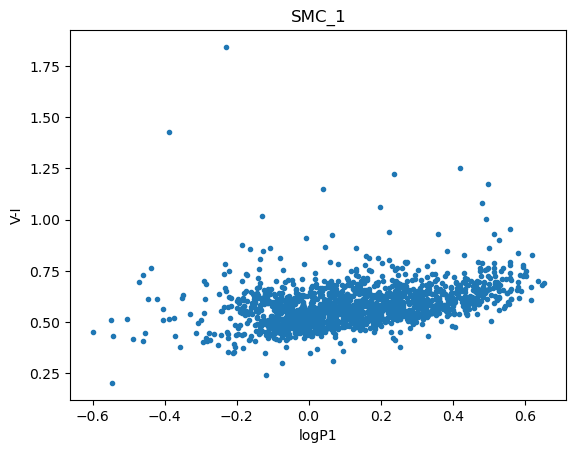

In [36]:
# log(P1) vs V-I

plt.plot(LMC_F['logP1'], LMC_F['VI'], '.')
plt.title('LMC_F')
plt.xlabel('logP1')
plt.ylabel('V-I')
plt.show()

plt.plot(LMC_1['logP1'], LMC_1['VI'], '.')
plt.title('LMC_1')
plt.xlabel('logP1')
plt.ylabel('V-I')
plt.show()

plt.plot(SMC_F['logP1'], SMC_F['VI'], '.')
plt.title('SMC_F')
plt.xlabel('logP1')
plt.ylabel('V-I')
plt.show()

plt.plot(SMC_1['logP1'], SMC_1['VI'], '.')
plt.title('SMC_1')
plt.xlabel('logP1')
plt.ylabel('V-I')
plt.show()

There may be a slight positive trend between the log of the period and V-I but it would be small. The width of the V-I range is fairly compact meaning these Cepheids come from stars within a tight temperature range.